<a href="https://colab.research.google.com/github/vedantdave77/Udacity_Nueral_network_pytorch/blob/master/CIFAR10__CNN_Pytorch_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Test Cuda availability 


In [49]:
import torch
import numpy as np 

# check cuda 
train_on_cuda  = torch.cuda.is_available()

if not train_on_cuda:
  print('cuda is not available')
else:
  print('cuda ia available, Yahoo!!!')


cuda ia available, Yahoo!!!


### Load data

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

num_workers = 0  # no of subprocesses to using data
batch_size = 20
valid_size = 0.2

transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


In [51]:
train_data = datasets.CIFAR10('data',train = True, download = True,transform = transform)
test_data = datasets.CIFAR10('data',train = False, download= True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# indices for validation
 num_train = len(train_data)
 indices = list(range(num_train))
 np.random.shuffle(indices)
 split = int(np.floor(valid_size * num_train))
 train_idx,valid_idx = indices[split:],indices[:split]


In [0]:
# data loader
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data,batch_size= batch_size,
                                           sampler = train_sampler, num_workers= num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size= batch_size,
                                           sampler = valid_sampler, num_workers= num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                          num_workers=num_workers)
                                           


In [0]:
# classes define 
classes = ['airplane','automobile','bird','cat','deer','dog','frog',
           'horse','ship','truck']

### Visulize a barch of training data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
  img= img/ 2 +0.5
  plt.imshow(np.transpose(img,(1,2,0)))
  


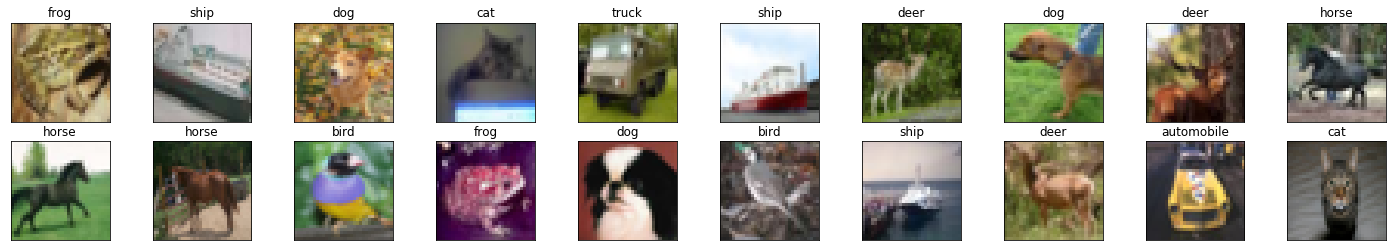

In [56]:
# now take bunch of data and use above defination for show training data
dataiter = iter(train_loader)
images,labels = dataiter.next()
images= images.numpy() # convert image to numpy for display

fig = plt.figure(figsize= (25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2,20/2,idx+1,xticks = [], yticks= [])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])


# view images in more detail

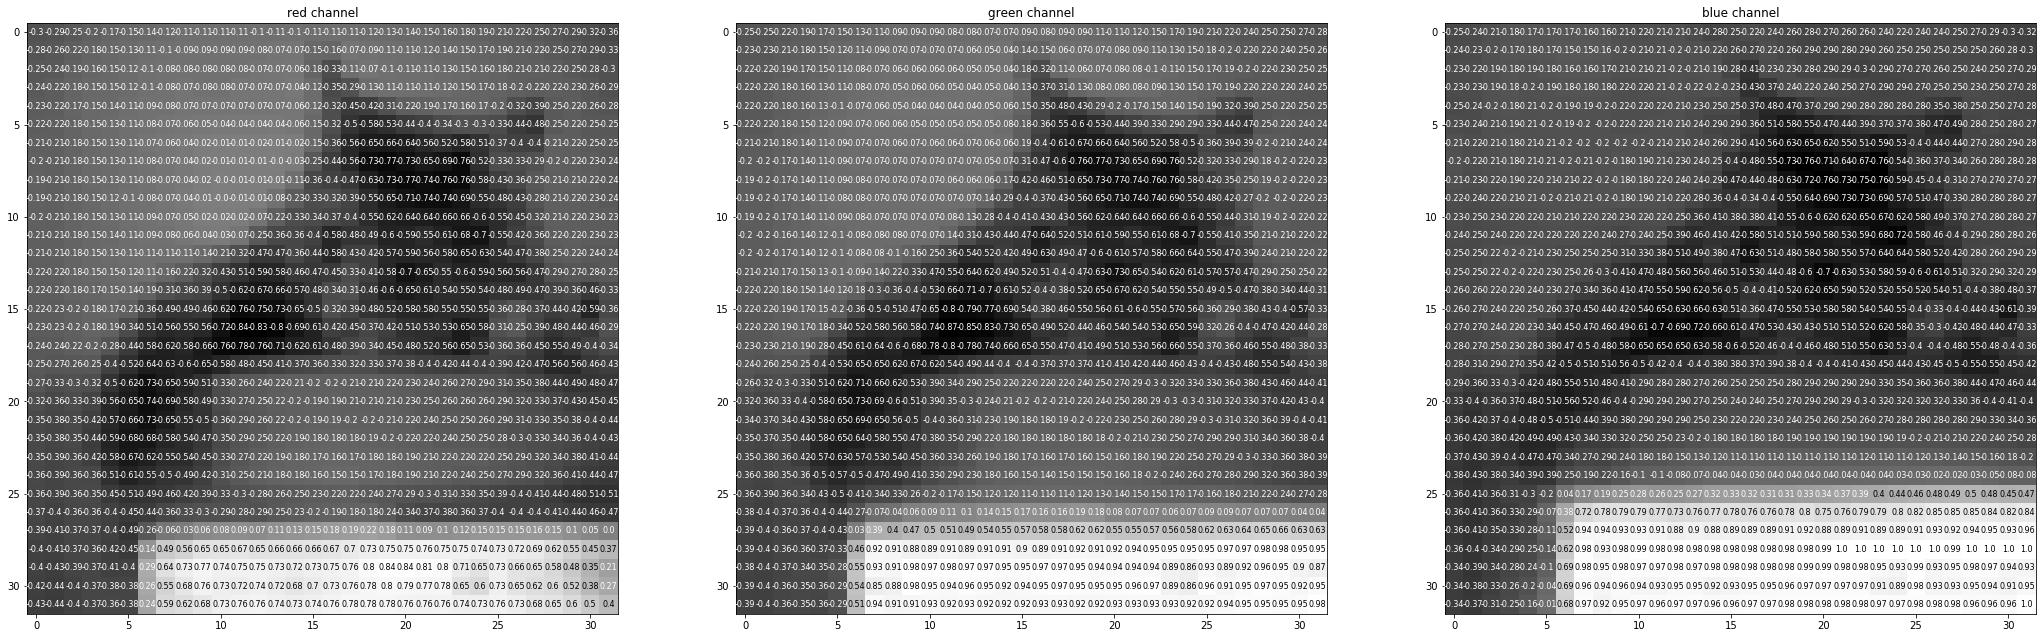

In [57]:
# seperate red, green and blue color channel as separate , graysclae intansity images
rgb_image = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig =plt.figure(figsize = (36,36))
for idx in np.arange(rgb_image.shape[0]):
  ax = fig.add_subplot(1,3,idx+1)
  img = rgb_image[idx]
  ax.imshow(img,cmap = 'gray')
  ax.set_title(channels[idx])
  width,height = img.shape
  thresh  = img.max()/2.5
  for x in range(width):
    for y in range(height):
      val = round(img[x][y],2) if img[x][y]!= 0 else 0
      ax.annotate(str(val),xy = (y,x),
                  horizontalalignment = 'center',
                  verticalalignment = 'center',
                  size = 8,
                  color = 'white' if img[x][y] <thresh else 'black')


# Define Network Architecture.

### This time we will use fully connected CNN instead of MLP and it will use convolutional and maxpooling layer

#### We will use linear + drop out layer for reduce the overfitting and in last stage it produce 10 dimension output.

In [68]:
import torch.nn as nn 
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,padding = 1)
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)

        #pooling layers
        self.pool = nn.MaxPool2d(2,2)
        #Linear layers
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        #drop_out
        self.dropout = nn.Dropout(0.25)
      
    def forward(self, x):
        # add sequence of conv. and max.pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #flatten image
        x = x.view(-1,64*4*4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = Net()
print(model)

if train_on_cuda:
  model.cuda()




Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify loss function and optimizer


In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01)


# Train network

In [70]:
n_epoches = 30 
valid_loss_min = np.Inf  # for traching the validation loss

for epoch in range(1,n_epoches+1):
    train_loss = 0.0
    valid_loss = 0.0

    # train the model
    model.train()
    for data,target in train_loader:
      if train_on_cuda:
        data,target = data.cuda(),target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output,target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)

    #validate the model
    model.eval()
    for data,target in valid_loader:
      if train_on_cuda:
        data,target= data.cuda(),target.cuda()
        output= model(data)
        loss = criterion(output,target)
        valid_loss +=loss.item()*data.size(0)
      
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('validation loss decresed ({:.6f} t0 {:.6f}). Saving model.no {}'
      .format(valid_loss_min,valid_loss,epoch))
    torch.save(model.state_dict(), 'model_cifar.pt')
    valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 2.123309 	Validation Loss: 1.886349
validation loss decresed (inf t0 1.886349). Saving model.no 1
Epoch: 2 	Training Loss: 1.687014 	Validation Loss: 1.508463
validation loss decresed (1.886349 t0 1.508463). Saving model.no 2
Epoch: 3 	Training Loss: 1.475550 	Validation Loss: 1.374807
validation loss decresed (1.508463 t0 1.374807). Saving model.no 3
Epoch: 4 	Training Loss: 1.368271 	Validation Loss: 1.308708
validation loss decresed (1.374807 t0 1.308708). Saving model.no 4
Epoch: 5 	Training Loss: 1.276247 	Validation Loss: 1.196592
validation loss decresed (1.308708 t0 1.196592). Saving model.no 5
Epoch: 6 	Training Loss: 1.193455 	Validation Loss: 1.134700
validation loss decresed (1.196592 t0 1.134700). Saving model.no 6
Epoch: 7 	Training Loss: 1.120449 	Validation Loss: 1.056808
validation loss decresed (1.134700 t0 1.056808). Saving model.no 7
Epoch: 8 	Training Loss: 1.052999 	Validation Loss: 1.011184
validation loss decresed (1.056808 t0 1.011184).

### Load the model with the lowest validation loss

In [71]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

### Test train Network

In [72]:
test_loss = 0.0 # for tracking the test loss

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data,target in test_loader:
  if train_on_cuda:
    data,target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output,target)
    test_loss += loss.item()*data.size(0)

    _,pred = torch.max(output,1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct =np.squeeze(correct_tensor.numpy()) if not train_on_cuda else np.squeeze(correct_tensor.cpu().numpy())
  
  #calculate accuracy oftest for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('')
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.777732
Test Accuracy of airplane: 74% (747/1000)
Test Accuracy of automobile: 84% (842/1000)
Test Accuracy of  bird: 65% (650/1000)
Test Accuracy of   cat: 57% (576/1000)
Test Accuracy of  deer: 75% (752/1000)
Test Accuracy of   dog: 64% (642/1000)
Test Accuracy of  frog: 88% (884/1000)
Test Accuracy of horse: 78% (786/1000)
Test Accuracy of  ship: 85% (850/1000)
Test Accuracy of truck: 79% (793/1000)


Test Accuracy (Overall): 75% (7522/10000)


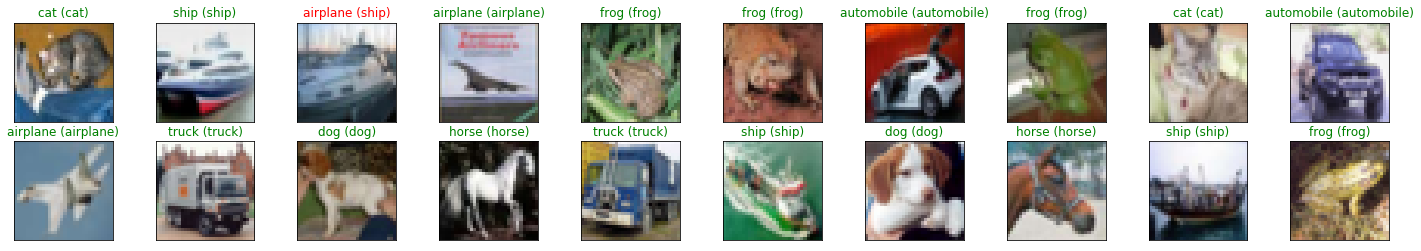

In [75]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_cuda:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [0]:
# Keep Learning, Enjoy Empowering